# 🌀 RealNVP

In this notebook, we'll walk through the steps required to train your own RealNVP network to predict the distribution of a demo dataset

The code has been adapted from the excellent [RealNVP tutorial](https://keras.io/examples/generative/real_nvp) created by Mandolini Giorgio Maria, Sanna Daniele and Zannini Quirini Giorgio available on the Keras website.

In [1]:
# Run these lines in Colab
!git clone https://github.com/mxagar/generative_ai_book.git
!mkdir notebooks
!mkdir chekpoint
!mkdir data
!mkdir output
!mkdir models
!mv generative_ai_book/notebooks/utils.py ./notebooks/utils.py
!mv generative_ai_book/notebooks/03_vae/03_vae_faces/vae_utils.py ./notebooks/vae_utils.py
!pip install python-dotenv

Cloning into 'generative_ai_book'...
remote: Enumerating objects: 778, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 778 (delta 211), reused 235 (delta 180), pack-reused 458 (from 1)
Receiving objects: 100% (778/778), 53.81 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (446/446), done.


In [2]:
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv()

# Set an environment variable
# Get values from ./scripts/download.sh
# E.g., celebrity faces dataset: jessicali9530, celeba-dataset
#os.environ['KAGGLE_DATASET_USER'] = 'hugodarwood'
#os.environ['KAGGLE_DATASET'] = 'epirecipes'

True

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    regularizers,
    metrics,
    optimizers,
    callbacks,
)
import tensorflow_probability as tfp

## 0. Parameters <a name="parameters"></a>

In [4]:
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

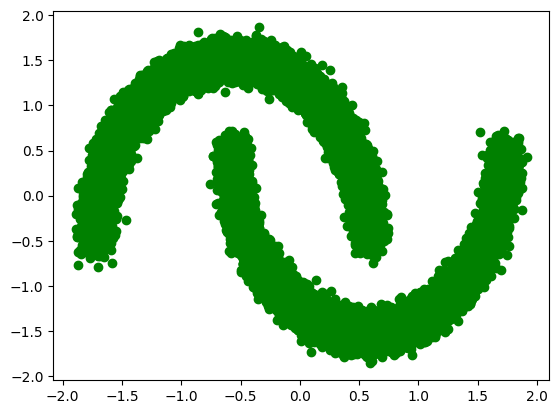

In [5]:
# Load the data
data = datasets.make_moons(30000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
plt.scatter(
    normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c="green"
)
plt.show()

## 2. Build the RealNVP network <a name="build"></a>

In [8]:
def Coupling(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=(input_dim,))

    s_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    s_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = layers.Dense(
        input_dim, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    t_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = layers.Dense(
        input_dim, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

In [9]:
class RealNVP(models.Model):
    def __init__(
        self, input_dim, coupling_layers, coupling_dim, regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)

## 3. Train the RealNVP network <a name="train"></a>

In [10]:
# Compile and train the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

In [11]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def generate(self):
        # From data to latent space.
        z, _ = model(normalized_data)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            normalized_data[:, 0], normalized_data[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            x, z, samples = self.generate()
            self.display(
                x,
                z,
                samples,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )


img_generator_callback = ImageGenerator(num_samples=3000)

Epoch 1/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.6813
Saved to ./output/generated_img_000.png


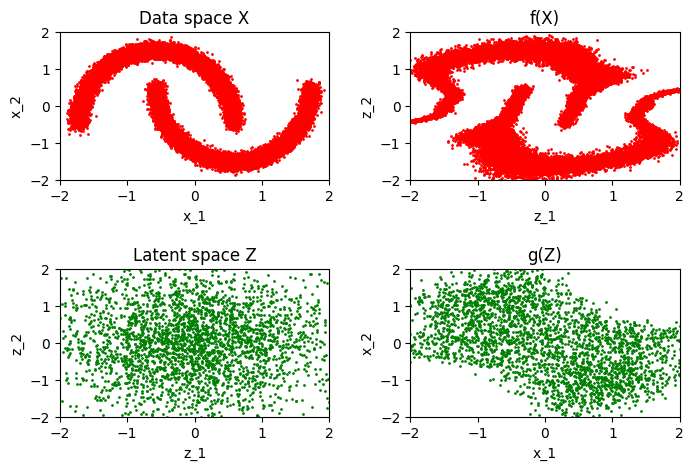

118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - loss: 2.6804
Epoch 2/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3713
Epoch 3/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2256
Epoch 4/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1063
Epoch 5/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0376
Epoch 6/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9912
Epoch 7/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9247
Epoch 8/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8071
Epoch 9/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7675
Epoch 10/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7647
Epoch 11/300
105/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7553
Saved to ./output/generated_img_010.png


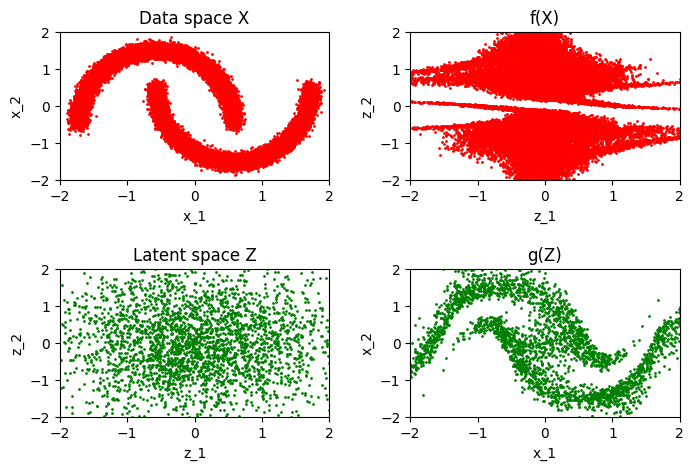

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7563
Epoch 12/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7561
Epoch 13/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7431
Epoch 14/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7468
Epoch 15/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7408
Epoch 16/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7392
Epoch 17/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7256
Epoch 18/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7343
Epoch 19/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7396
Epoch 20/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7280
Epoch 21/300
111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7249
Saved to ./output/generated_img_020.png


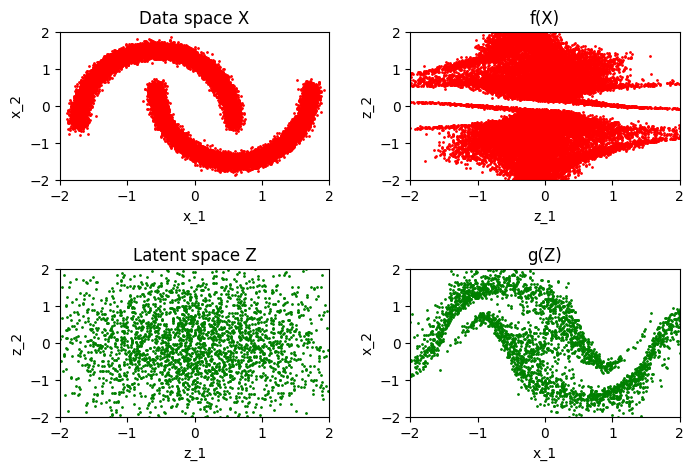

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7251
Epoch 22/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7287
Epoch 23/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7382
Epoch 24/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7255
Epoch 25/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7247
Epoch 26/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7260
Epoch 27/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7268
Epoch 28/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7288
Epoch 29/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7201
Epoch 30/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7287
Epoch 31/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7252
Saved to ./output/generated_img_030.png


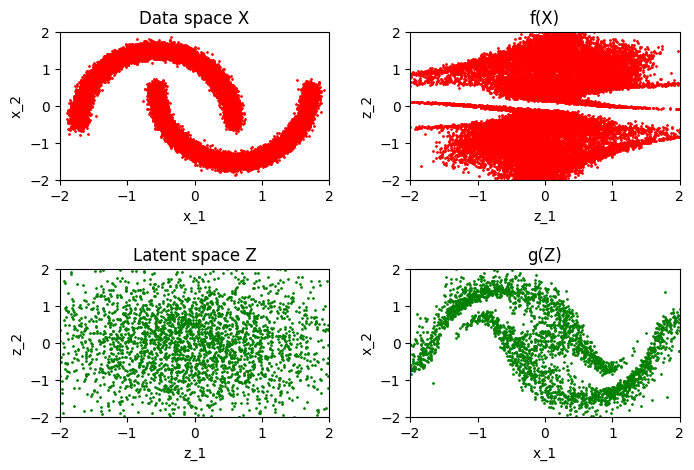

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7251
Epoch 32/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7354
Epoch 33/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7273
Epoch 34/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7207
Epoch 35/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7276
Epoch 36/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7225
Epoch 37/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7274
Epoch 38/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7468
Epoch 39/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7182
Epoch 40/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7213
Epoch 41/300
110/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7327
Saved to ./output/generated_img_040.png


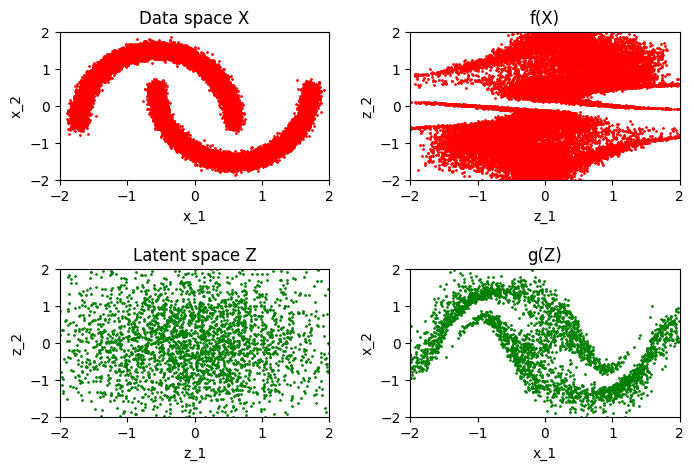

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.7320
Epoch 42/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7380
Epoch 43/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7286
Epoch 44/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7141
Epoch 45/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7196
Epoch 46/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7184
Epoch 47/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7142
Epoch 48/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7197
Epoch 49/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7282
Epoch 50/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7275
Epoch 51/300
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7346
Saved to ./output/generated_img_050.png


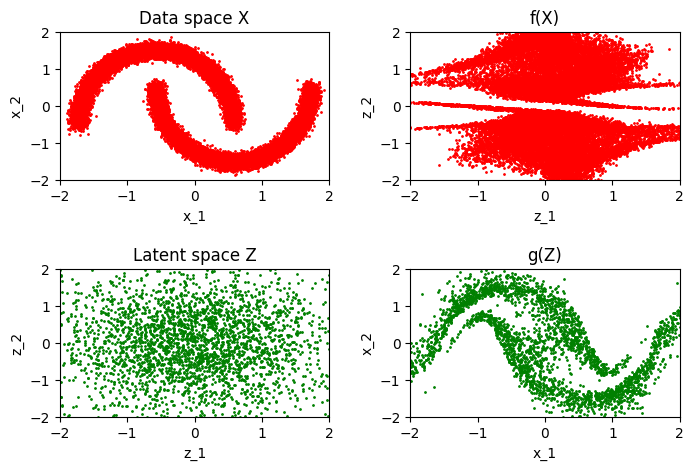

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7342
Epoch 52/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7126
Epoch 53/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7125
Epoch 54/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7416
Epoch 55/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7186
Epoch 56/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7280
Epoch 57/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7280
Epoch 58/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7282
Epoch 59/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7147
Epoch 60/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7175
Epoch 61/300
106/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7170
Saved to ./output/generated_img_060.png


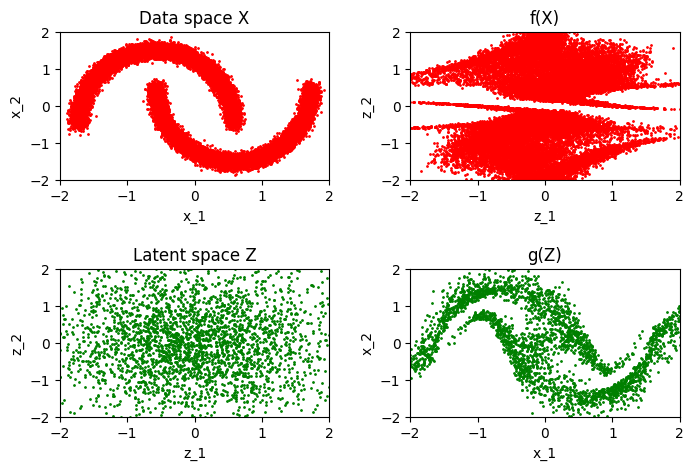

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7173
Epoch 62/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7183
Epoch 63/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7102
Epoch 64/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7264
Epoch 65/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7116
Epoch 66/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7123
Epoch 67/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7253
Epoch 68/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7147
Epoch 69/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7172
Epoch 70/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7176
Epoch 71/300
113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7197
Saved to ./output/generated_img_070.png


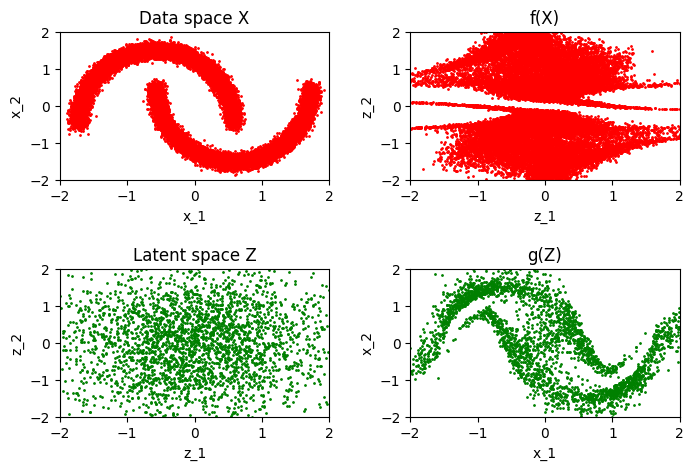

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7195
Epoch 72/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7137
Epoch 73/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7228
Epoch 74/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7159
Epoch 75/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7216
Epoch 76/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7268
Epoch 77/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7142
Epoch 78/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7270
Epoch 79/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7227
Epoch 80/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7072
Epoch 81/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7158
Saved to ./output/generated_img_080.png


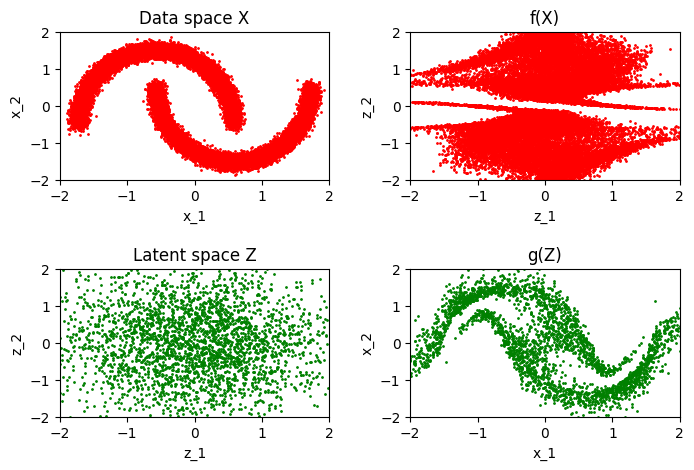

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7158
Epoch 82/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7162
Epoch 83/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7136
Epoch 84/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7164
Epoch 85/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7118
Epoch 86/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7191
Epoch 87/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7144
Epoch 88/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7128
Epoch 89/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7324
Epoch 90/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7191
Epoch 91/300
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7089
Saved to ./output/generated_img_090.png


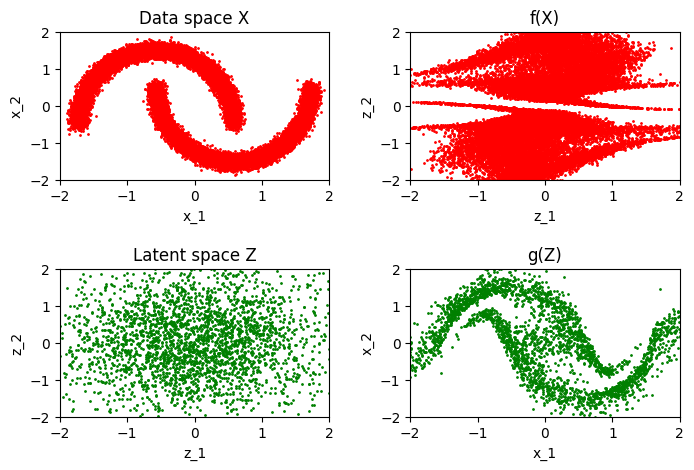

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.7091
Epoch 92/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7249
Epoch 93/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7130
Epoch 94/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7071
Epoch 95/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7199
Epoch 96/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7156
Epoch 97/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7474
Epoch 98/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7224
Epoch 99/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7162
Epoch 100/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7118
Epoch 101/300
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7355
Saved to ./output/generated_img_100.png


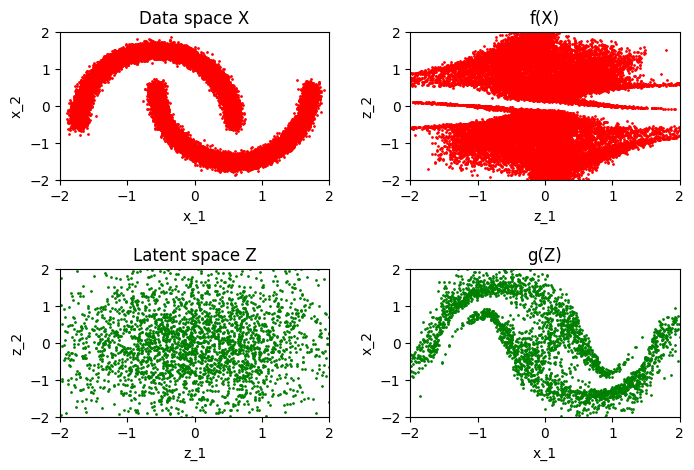

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7351
Epoch 102/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7079
Epoch 103/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7133
Epoch 104/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7068
Epoch 105/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7162
Epoch 106/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7174
Epoch 107/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7320
Epoch 108/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7165
Epoch 109/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7177
Epoch 110/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7132
Epoch 111/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7294
Saved to ./output/generated_img_110.png


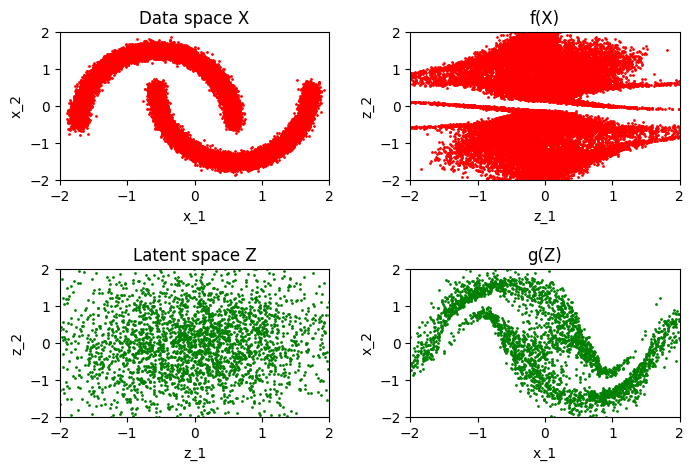

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7292
Epoch 112/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7119
Epoch 113/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7135
Epoch 114/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7180
Epoch 115/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7049
Epoch 116/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7426
Epoch 117/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7135
Epoch 118/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7107
Epoch 119/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7079
Epoch 120/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7172
Epoch 121/300
108/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7066
Saved to ./output/generated_img_120.png


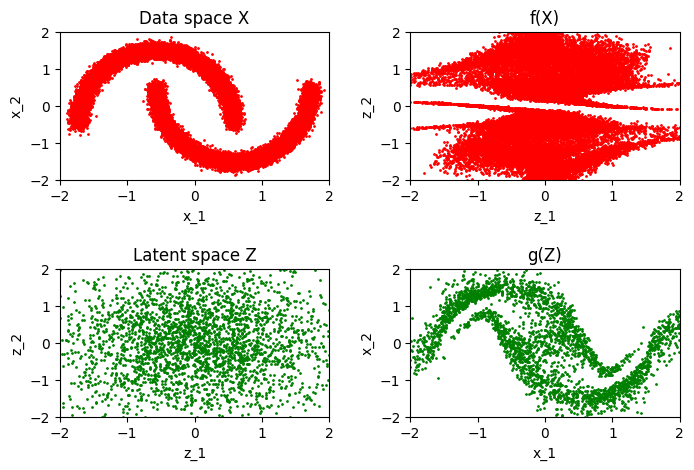

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.7072
Epoch 122/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7097
Epoch 123/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7052
Epoch 124/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7091
Epoch 125/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7211
Epoch 126/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7092
Epoch 127/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7091
Epoch 128/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7086
Epoch 129/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7100
Epoch 130/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7114
Epoch 131/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7133
Saved to ./output/generated_img_130.png


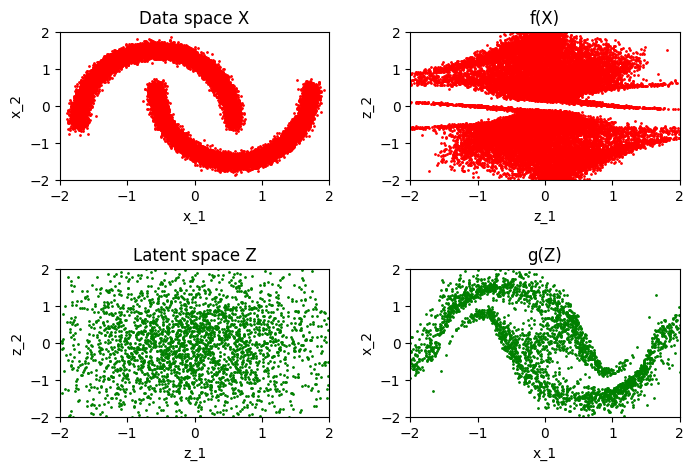

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7132
Epoch 132/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7023
Epoch 133/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7125
Epoch 134/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7080
Epoch 135/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7160
Epoch 136/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7068
Epoch 137/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7092
Epoch 138/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7244
Epoch 139/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7136
Epoch 140/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7042
Epoch 141/300
108/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7156
Saved to ./output/generated_img_140.png


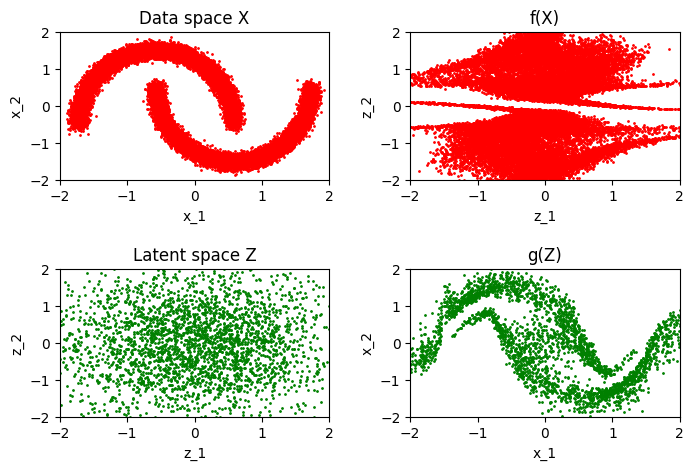

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7152
Epoch 142/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7227
Epoch 143/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7096
Epoch 144/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7127
Epoch 145/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7057
Epoch 146/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7086
Epoch 147/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7327
Epoch 148/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7092
Epoch 149/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7150
Epoch 150/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7202
Epoch 151/300
112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7111
Saved to ./output/generated_img_150.png


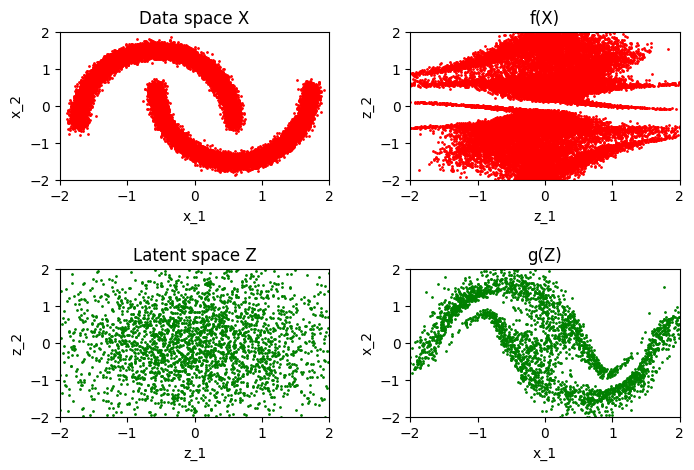

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7111
Epoch 152/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.7157
Epoch 153/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7194
Epoch 154/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7151
Epoch 155/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7069
Epoch 156/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7026
Epoch 157/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6981
Epoch 158/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7131
Epoch 159/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7094
Epoch 160/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7180
Epoch 161/300
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7270
Saved to ./output/generated_img_160.png


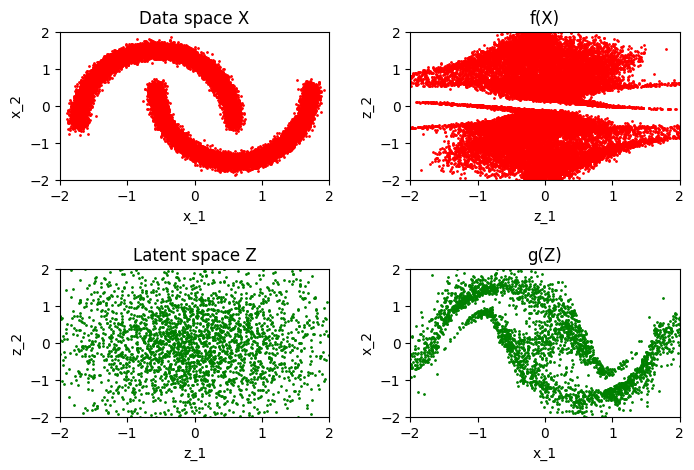

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7267
Epoch 162/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7087
Epoch 163/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7075
Epoch 164/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7157
Epoch 165/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7155
Epoch 166/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7169
Epoch 167/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7130
Epoch 168/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7063
Epoch 169/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7073
Epoch 170/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7088
Epoch 171/300
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7222
Saved to ./output/generated_img_170.png


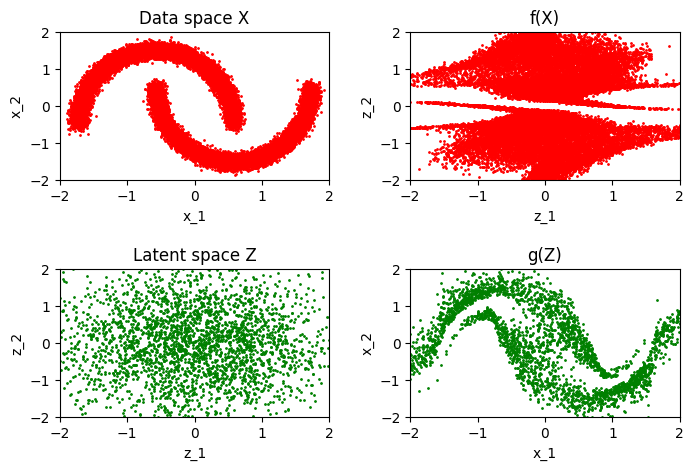

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7217
Epoch 172/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7172
Epoch 173/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7051
Epoch 174/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7130
Epoch 175/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7097
Epoch 176/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7156
Epoch 177/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7156
Epoch 178/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7201
Epoch 179/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7121
Epoch 180/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7126
Epoch 181/300
111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7014
Saved to ./output/generated_img_180.png


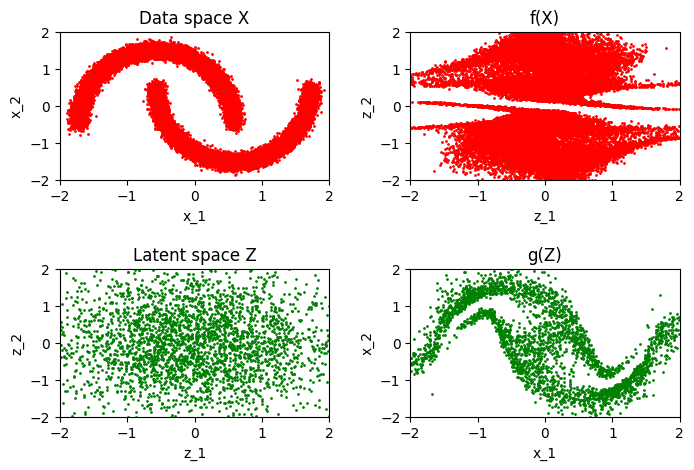

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7019
Epoch 182/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7072
Epoch 183/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7046
Epoch 184/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6986
Epoch 185/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6989
Epoch 186/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7171
Epoch 187/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7119
Epoch 188/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7089
Epoch 189/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7135
Epoch 190/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7021
Epoch 191/300
111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7079
Saved to ./output/generated_img_190.png


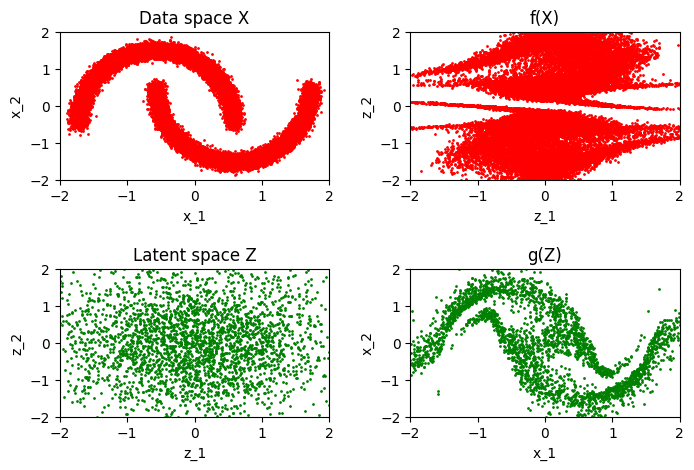

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7079
Epoch 192/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7117
Epoch 193/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7062
Epoch 194/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6983
Epoch 195/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7105
Epoch 196/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7060
Epoch 197/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7053
Epoch 198/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7132
Epoch 199/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7071
Epoch 200/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7128
Epoch 201/300
112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7087
Saved to ./output/generated_img_200.png


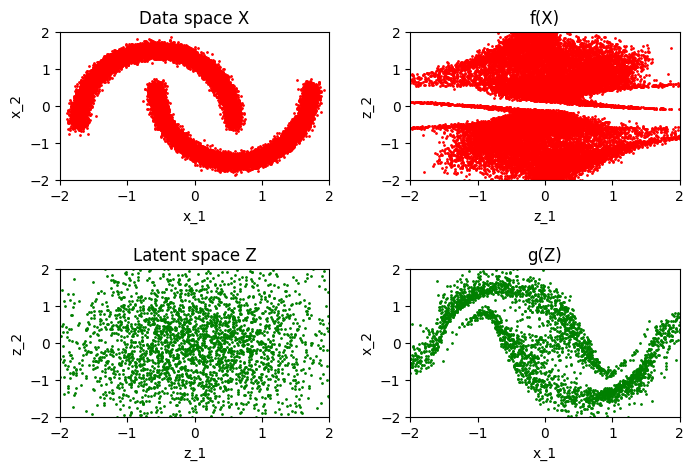

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7087
Epoch 202/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7054
Epoch 203/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7053
Epoch 204/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7059
Epoch 205/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7221
Epoch 206/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7072
Epoch 207/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7006
Epoch 208/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7063
Epoch 209/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7100
Epoch 210/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7342
Epoch 211/300
112/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7056
Saved to ./output/generated_img_210.png


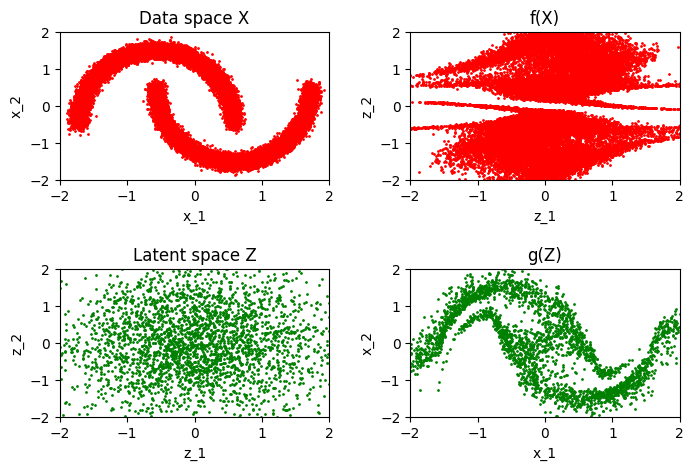

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7058
Epoch 212/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7130
Epoch 213/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7050
Epoch 214/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7108
Epoch 215/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7098
Epoch 216/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7172
Epoch 217/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7145
Epoch 218/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7027
Epoch 219/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7095
Epoch 220/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7093
Epoch 221/300
110/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7047
Saved to ./output/generated_img_220.png


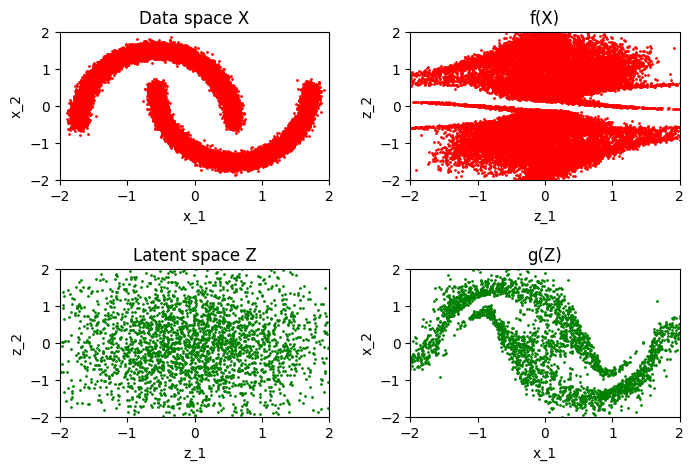

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7049
Epoch 222/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7024
Epoch 223/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7073
Epoch 224/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7012
Epoch 225/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7002
Epoch 226/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7137
Epoch 227/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7036
Epoch 228/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7010
Epoch 229/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7188
Epoch 230/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7073
Epoch 231/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7051
Saved to ./output/generated_img_230.png


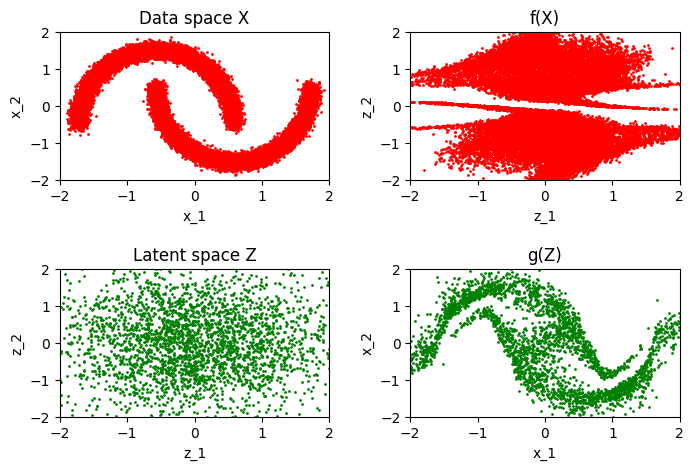

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.7051
Epoch 232/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7047
Epoch 233/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7087
Epoch 234/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6962
Epoch 235/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7031
Epoch 236/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7055
Epoch 237/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7099
Epoch 238/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7191
Epoch 239/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7091
Epoch 240/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7048
Epoch 241/300
110/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7100
Saved to ./output/generated_img_240.png


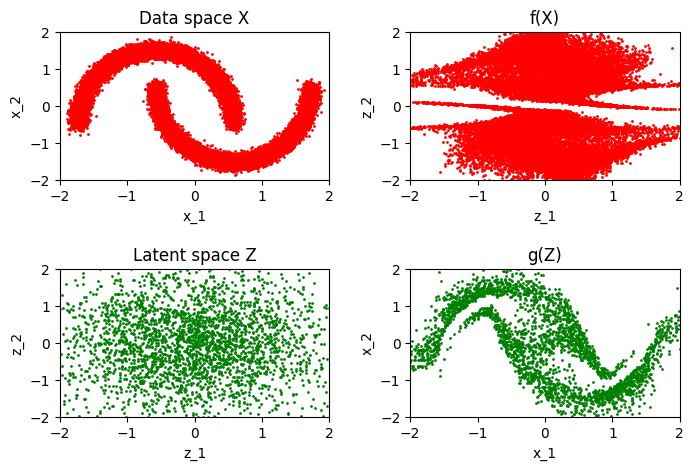

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7100
Epoch 242/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7027
Epoch 243/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7080
Epoch 244/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7098
Epoch 245/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6941
Epoch 246/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7005
Epoch 247/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7013
Epoch 248/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7081
Epoch 249/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7111
Epoch 250/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7009
Epoch 251/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7041
Saved to ./output/generated_img_250.png


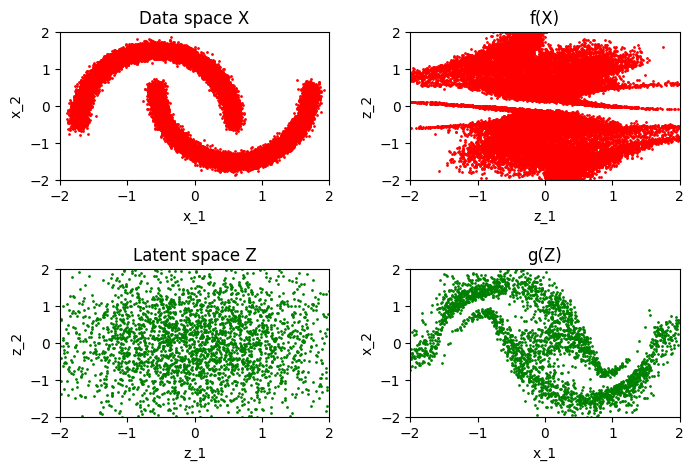

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7041
Epoch 252/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7123
Epoch 253/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7040
Epoch 254/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7036
Epoch 255/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7067
Epoch 256/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7140
Epoch 257/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7101
Epoch 258/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7132
Epoch 259/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7168
Epoch 260/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7083
Epoch 261/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7052
Saved to ./output/generated_img_260.png


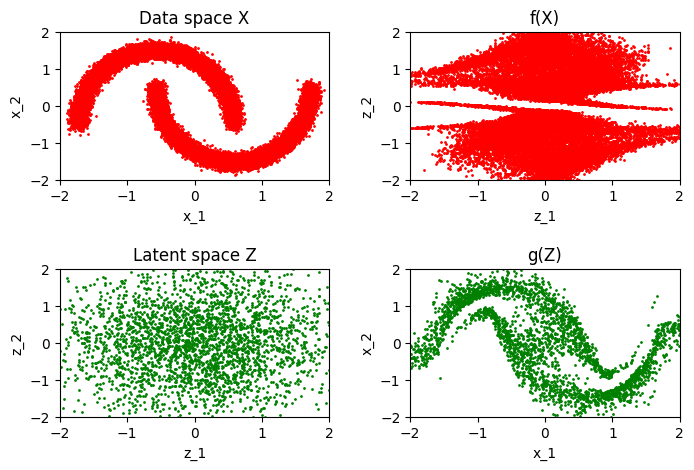

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7052
Epoch 262/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7006
Epoch 263/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7000
Epoch 264/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7010
Epoch 265/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6959
Epoch 266/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7126
Epoch 267/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7027
Epoch 268/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7155
Epoch 269/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7044
Epoch 270/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7075
Epoch 271/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7068
Saved to ./output/generated_img_270.png


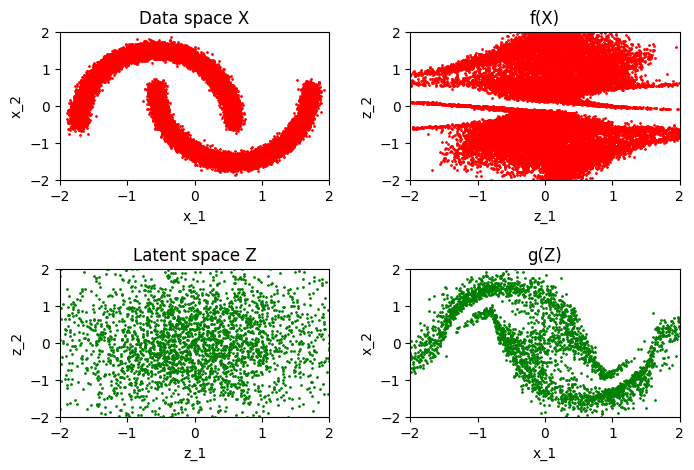

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7068
Epoch 272/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6991
Epoch 273/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7063
Epoch 274/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7149
Epoch 275/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7030
Epoch 276/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7111
Epoch 277/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7131
Epoch 278/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7081
Epoch 279/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7101
Epoch 280/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7084
Epoch 281/300
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7058
Saved to ./output/generated_img_280.png


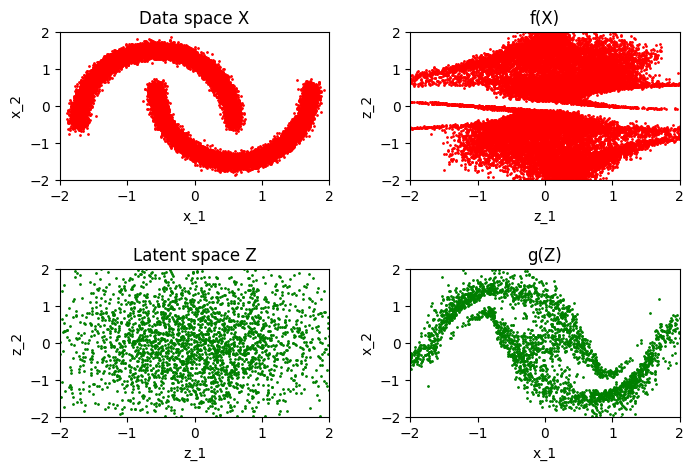

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7058
Epoch 282/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7075
Epoch 283/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7006
Epoch 284/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7140
Epoch 285/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7057
Epoch 286/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7058
Epoch 287/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7145
Epoch 288/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7090
Epoch 289/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7071
Epoch 290/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7034
Epoch 291/300
113/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7080
Saved to ./output/generated_img_290.png


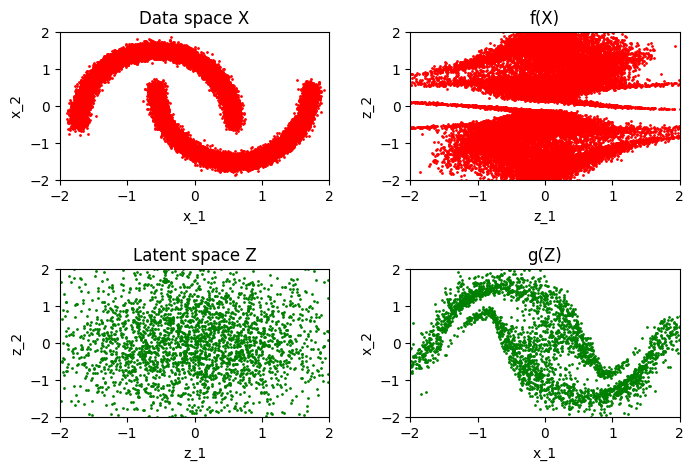

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.7078
Epoch 292/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7005
Epoch 293/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7126
Epoch 294/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7181
Epoch 295/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7072
Epoch 296/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7088
Epoch 297/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7122
Epoch 298/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7104
Epoch 299/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7066
Epoch 300/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7296


In [12]:
model.fit(
    normalized_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. Generate images <a name="generate"></a>

In [13]:
x, z, samples = img_generator_callback.generate()

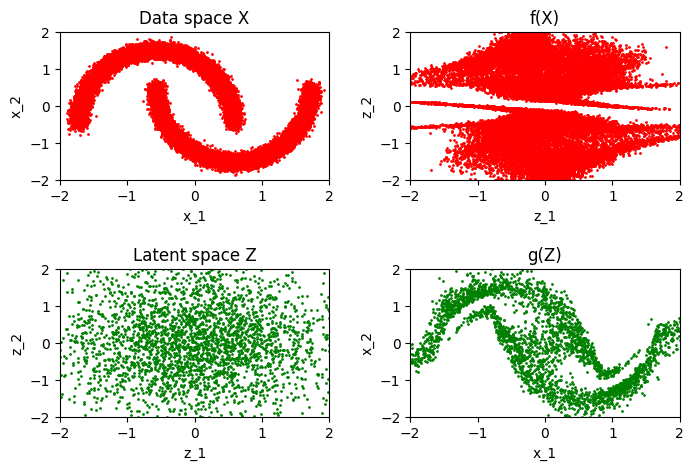

In [14]:
img_generator_callback.display(x, z, samples)